# Import Packages

In [2]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm.auto import trange, tqdm
import h5py
from itertools import product, zip_longest
import torch

c:\co\NIA\.grif_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define Parameters

In [32]:
SNR = 10
n_elements = 128
d_start = 4
d_increment = 4

n_noise_realizations = 10
n_datasets = 5

lambdaA = -6
lambdaB = 1
default_lambdas = np.append(0, np.logspace(lambdaA,lambdaB,51))

assert(np.all(default_lambdas>=0))

GSS_tolerance = 10**-4

goldRat = (5**(1/2)-1)/2
est_GSS_steps = np.ceil((np.log(GSS_tolerance) - np.log(lambdaB-lambdaA))/np.log(goldRat))+1
print(est_GSS_steps)

tdata = np.linspace(d_start, d_increment*n_elements, n_elements)
assert(tdata[0]==d_start)
assert(tdata[-1]==d_increment*n_elements)

############
#Test case to ensure everything is working
lambdas_test = np.append(0, np.logspace(lambdaA, lambdaB, int(est_GSS_steps)))
lambdas_comprehensive = np.append(0, np.logspace(lambdaA, lambdaB, 251))

c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 200

ob_weight = 100
upper_bound = [1,1,500,1500] #Set upper bound on parameters c1, c2, T21, T22, respectively
true_params = np.array([c1, c2, T21, T22]) #Set initial guesses
initial_params = true_params
# initial_params = (0.5, 0.5, 250, 750) #Arbitrary params
agg_array = np.array([1,1,1/ob_weight, 1/ob_weight])
# agg_array = np.array(1/initial_params)

round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)

############
#Actual parameter sets to investigate
c1_set = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
c2_set = 1 - c1_set
T21_set = np.array([10, 20, 30, 40, 50, 60])
T22_set = np.array([70, 85, 100, 120, 150, 200])
n_param_sets = c1_set.size * T21_set.size * T22_set.size

SNR_set = np.array([10, 50, 100, 175, 300])

plt.style.use('default')

25.0


# Define Signal Functions

In [4]:
#Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G3(t, con_1, tau_1, tau_2): 
    con_2 = 1 - con_1
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, agg_arr = agg_array):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    agg_arr = lam*agg_arr
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [con1, con2, tau1,tau2]*agg_arr)
    return Gt_lam

def noise(sd):
    return np.random.normal(0, sd, n_elements)

def add_noise(signal, SNR):
    #Given a noiseless signal, adds noise at given SNR and returns a noisy signal
    signal_length = len(signal)
    noise_sd = signal[0]/SNR
    noisy_signal = signal + np.random.normal(0, noise_sd, signal_length)
    return noisy_signal

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, noise_sd):
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2)
    covariance = np.linalg.inv(jacobians)
    return noise_sd**2*covariance

# Define Regularization and Estimation Functions

In [9]:
def estimate_parameters(data, lam, init_p0 = initial_params):
    data_tilde = np.append(data, [0,0,0,0])
    
    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, upper_bound), p0=init_p0, max_nfev = 4000)
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
        
    return c1est, c2est, T21est, T22est

def minLambda_objFunc(lamb, noisey_data, p_true, init_params = initial_params, agg_arr = agg_array, omni = False):

    p_est = np.array(estimate_parameters(noisey_data, lamb, init_p0 = init_params))
    obj_value = np.linalg.norm(agg_arr*(p_est-p_true))
    
    if omni:
        return obj_value, p_est
    else:
        return obj_value
    
def find_minLambda_L2grid_omni(noisey_data, p_true, lambdas = default_lambdas):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        error, est = minLambda_objFunc(lam,noisey_data, p_true, omni = True)
        estimates.append(np.array(est))
        abs_error_list.append(error)
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list

def find_minLambda_L1grid_omni(noisey_data, p_true, lambdas = default_lambdas, agg_arr = agg_array):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        error, est = minLambda_objFunc(lam,noisey_data, p_true, omni = True)
        estimates.append(np.array(est))
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr)) #product and sum of the scaled vector
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda, abs_error_list

def generate_Lcurve_data(noisey_data, p_true, lambdas = default_lambdas):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    abs_error_list = []
    param_estimates = []
    for lam in lambdas:
        error, est = minLambda_objFunc(lam,noisey_data, p_true, omni = True)
        param_estimates.append(np.array(est))
        abs_error_list.append(error)

    return param_estimates, abs_error_list

def find_minLambda_GSS_omni(noisey_data, p_true, tolerance = GSS_tolerance, lambdaA = lambdaA, lambdaB = lambdaB):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    goldRat = (5**(1/2)-1)/2

    lambdaList = []
    errorList = []
    paramEstimates = []

    lam_low = lambdaA + (1-goldRat)*(lambdaB - lambdaA)
    lam_high = lambdaA + (goldRat)*(lambdaB - lambdaA)

    lambdaList.append(10**lam_low)
    lambdaList.append(10**lam_high)

    #Getting an initial measure of the parameters 
    error_low, est_low = minLambda_objFunc(10**lam_low, noisey_data, p_true, omni = True)
    error_high, est_high = minLambda_objFunc(10**lam_high, noisey_data, p_true, omni = True)

    paramEstimates.append(est_low)
    paramEstimates.append(est_high)

    errorList.append(error_low)
    errorList.append(error_high)

    regionThreshold = np.abs(lam_high-lam_low)
    while regionThreshold>tolerance:

        if error_low > error_high:
            lambdaA = lam_low
            lam_low = lam_high
            lam_high = lambdaA + (goldRat)*(lambdaB - lambdaA)
            assert(lam_low < lam_high)

            lambdaList.append(10**lam_high)

            error_low = error_high
            error_high, est_high = minLambda_objFunc(10**lam_high, noisey_data, p_true, omni = True)
            
            paramEstimates.append(est_high)
            errorList.append(error_high)

        else:
            lambdaB = lam_high
            lam_high = lam_low
            lam_low = lambdaA + (1-goldRat)*(lambdaB - lambdaA)
            assert(lam_low < lam_high)

            lambdaList.append(10**lam_low)

            error_high = error_low
            error_low, est_low = minLambda_objFunc(10**lam_low, noisey_data, p_true, omni = True)

            paramEstimates.append(est_low)
            errorList.append(error_low)

        regionThreshold = np.abs(lam_high-lam_low)
    
    min_error_index = np.argmin(errorList)
    min_error_lambda = lambdaList[min_error_index]
    min_error_est = paramEstimates[min_error_index]

    return min_error_est, min_error_lambda, lambdaList, errorList

# Visualize Minimum Lambda - Grid Method

'RSS of unregularized = 3.95e-02'

'RSS of L2 lambda_opt = 3.16e-02'

'RSS of L1 lambda_opt = 3.16e-02'

C:\Users\griff\AppData\Local\Temp\ipykernel_4660\1503232776.py:26: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(lambdas_comprehensive), error_array_comp, label = 'Universal Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
C:\Users\griff\AppData\Local\Temp\ipykernel_4660\1503232776.py:35: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(lambdas_test), error_array_L1, label = 'L1 Norm Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
C:\Users\griff\AppData\Local\Temp\ipykernel_4660\1503232776.py:37: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(lambdas_test), error_array_L2, label = 'L2 Norm Lambdas', alpha = 0.7, color ='b', ls = '-', marker = '*')


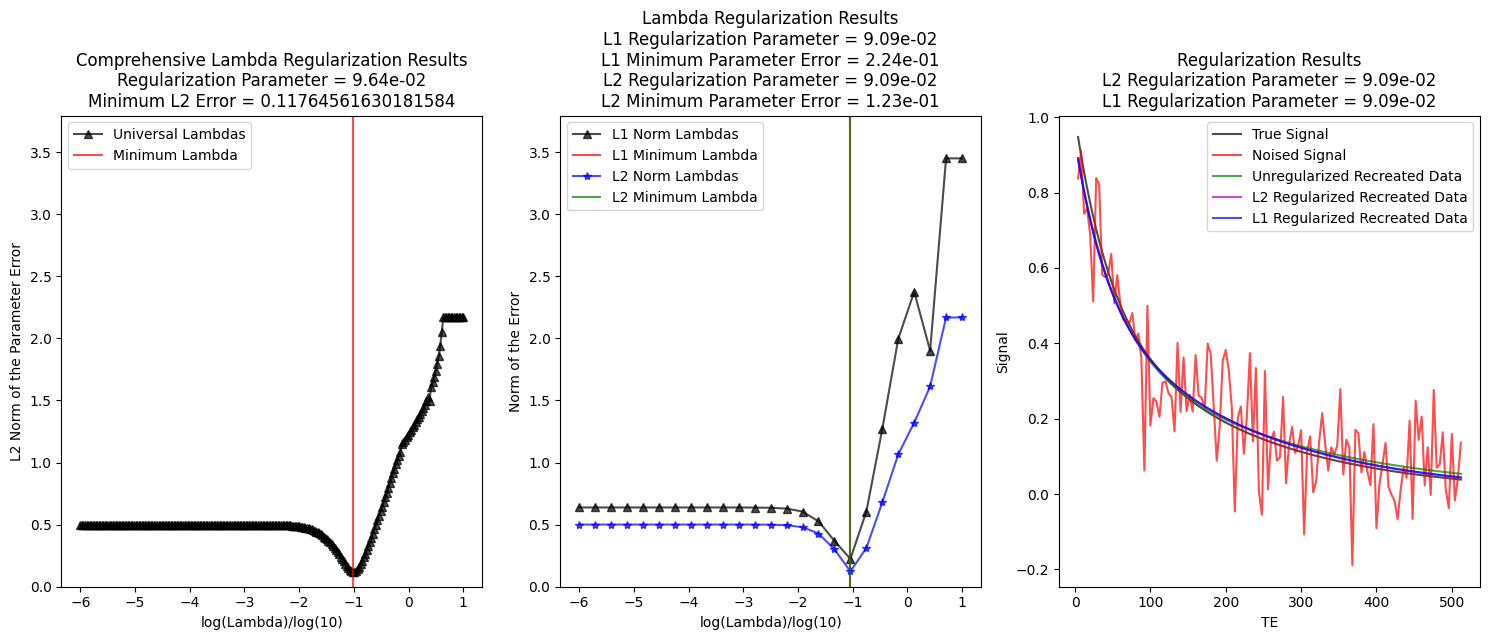

In [10]:
noiseless_curve = G(tdata, c1, c2, T21, T22)

data = add_noise(noiseless_curve, SNR)

unreg_params = estimate_parameters(data, 0)

opt_params_comp, min_error_lambda_comp, error_array_comp = find_minLambda_L2grid_omni(data, true_params, lambdas = lambdas_comprehensive)
opt_params_L2, min_error_lambda_L2, error_array_L2 = find_minLambda_L2grid_omni(data, true_params, lambdas = lambdas_test)
opt_params_L1, min_error_lambda_L1, error_array_L1 = find_minLambda_L1grid_omni(data, true_params, lambdas = lambdas_test)

unreg_curve = G(tdata, *unreg_params)
recreated_curve_L2 = G(tdata, *opt_params_L2)
recreated_curve_L1 = G(tdata, *opt_params_L1)

unreg_RSS = np.sum((noiseless_curve - unreg_curve)**2)
recreated_RSS_L2 = np.sum((noiseless_curve - recreated_curve_L2)**2)
recreated_RSS_L1 = np.sum((noiseless_curve - recreated_curve_L1)**2)

display('RSS of unregularized = ' + "{:.2e}".format(unreg_RSS))
display('RSS of L2 lambda_opt = ' + "{:.2e}".format(recreated_RSS_L2))
display('RSS of L1 lambda_opt = ' + "{:.2e}".format(recreated_RSS_L1))

opt_ymax = 1.1*np.max([np.max(error_array_L1),np.max(error_array_L2),np.max(error_array_comp)])

fig, ax = plt.subplots(1,3,figsize=(15,6.5), tight_layout=True)
ax[0].plot(np.log10(lambdas_comprehensive), error_array_comp, label = 'Universal Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=np.log10(min_error_lambda_comp), label = 'Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[0].set_xlabel('log(Lambda)/log(10)')
ax[0].set_ylabel('L2 Norm of the Parameter Error')
ax[0].set_ylim((0,opt_ymax))
ax[0].set_title('Comprehensive Lambda Regularization Results' + 
                '\nRegularization Parameter = ' + "{:.2e}".format(min_error_lambda_comp) + '\nMinimum L2 Error = ' + str(np.min(error_array_comp)))
ax[0].legend()

ax[1].plot(np.log10(lambdas_test), error_array_L1, label = 'L1 Norm Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axvline(x=np.log10(min_error_lambda_L1), label = 'L1 Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[1].plot(np.log10(lambdas_test), error_array_L2, label = 'L2 Norm Lambdas', alpha = 0.7, color ='b', ls = '-', marker = '*')
ax[1].axvline(x=np.log10(min_error_lambda_L2), label = 'L2 Minimum Lambda', alpha = 0.7, color ='g', ls = '-')
ax[1].set_xlabel('log(Lambda)/log(10)')
ax[1].set_ylabel('Norm of the Error')
ax[1].set_ylim((0,opt_ymax))
ax[1].set_title('Lambda Regularization Results' 
                + '\nL1 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L1)
                + '\nL1 Minimum Parameter Error = {:.2e}'.format(np.min(error_array_L1))
                + '\nL2 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L2)
                + '\nL2 Minimum Parameter Error = {:.2e}'.format(np.min(error_array_L2)))
ax[1].legend()


ax[2].plot(tdata, noiseless_curve, label = 'True Signal', alpha = 0.7, color ='k', ls = '-')
ax[2].plot(tdata, data, label = 'Noised Signal', alpha = 0.7, color ='r', ls = '-')
ax[2].plot(tdata, unreg_curve, label = 'Unregularized Recreated Data', alpha = 0.7, color ='g', ls = '-')
ax[2].plot(tdata, recreated_curve_L2, label = 'L2 Regularized Recreated Data', alpha = 0.7, color ='m', ls = '-')
ax[2].plot(tdata, recreated_curve_L1, label = 'L1 Regularized Recreated Data', alpha = 0.7, color ='b', ls = '-')
ax[2].set_xlabel('TE')
ax[2].set_ylabel('Signal')
ax[2].set_title('Regularization Results' + '\nL2 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L2) + 
            '\nL1 Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_L1))
ax[2].legend()

# Visualize Minimum Lambda - Golden Section Search Method

C:\Users\griff\AppData\Local\Temp\ipykernel_4660\3968734882.py:38: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(lambdas_comprehensive), error_array_comp, label = 'Universal Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
C:\Users\griff\AppData\Local\Temp\ipykernel_4660\3968734882.py:48: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(lambdas_test), error_array_grid, label = 'Grid Error', alpha = 0.7, color ='k', ls = '-', marker = '^')


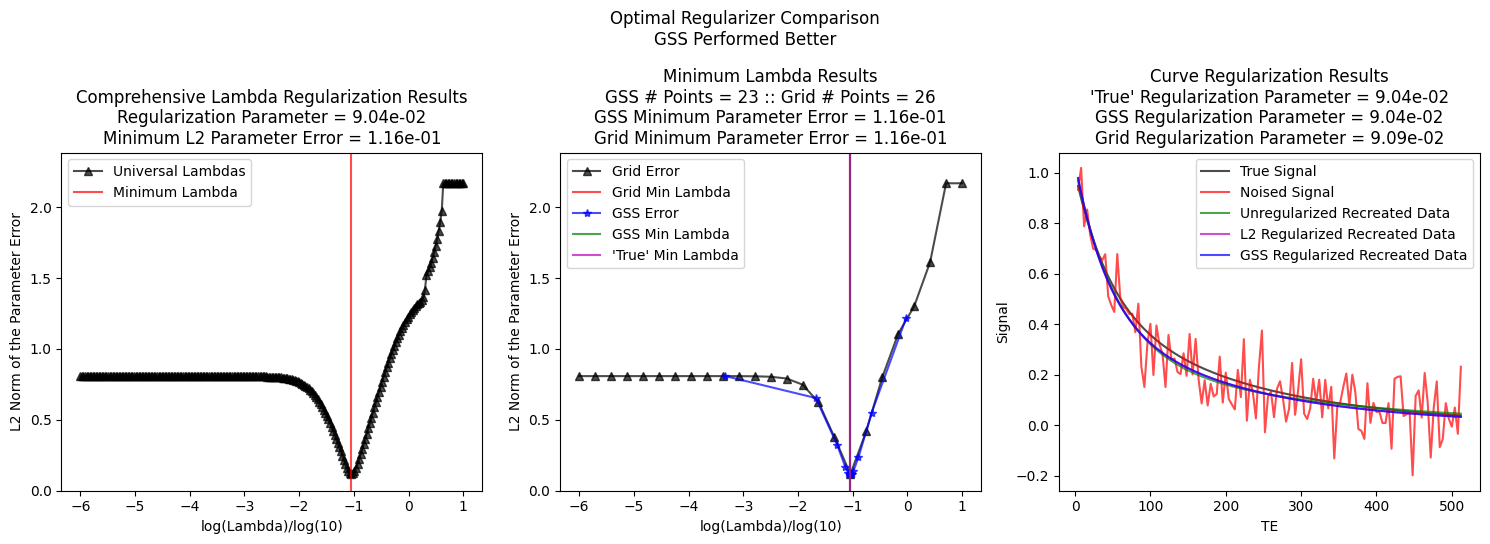

'Unreg RSS L2 0.056400287055694394'

'GSS RSS L2 0.048756653122018795'

'Grid RSS L2 0.04876898114015228'

'------------------------------------'

'Unreg RSS L1 2.1038064091851076'

'GSS RSS L1 2.2203110765587226'

'Grid RSS L1 2.222770201463779'

'------------------------------------'

'Unreg RSS Noised L2 1.0298891322081574'

'GSS RSS Noised L2 1.0386896382479291'

'Grid RSS Noised L2 1.0387755120724063'

In [11]:
noiseless_curve = G(tdata, c1, c2, T21, T22)

data = add_noise(noiseless_curve, SNR)

unreg_params = estimate_parameters(data, 0)

opt_params_comp, min_error_lambda_comp, error_array_comp = find_minLambda_L2grid_omni(data, true_params, lambdas = lambdas_comprehensive)
opt_params_GSS, min_error_lambda_GSS, lambda_list_GSS, error_array_GSS = find_minLambda_GSS_omni(data, true_params)
opt_params_grid, min_error_lambda_grid, error_array_grid = find_minLambda_L2grid_omni(data, true_params, lambdas = lambdas_test)

lamda_list_ind_sort = np.argsort(lambda_list_GSS)
lambda_list_sorted = np.take_along_axis(np.array(lambda_list_GSS), lamda_list_ind_sort, axis=0)
error_array_sorted = np.take_along_axis(np.array(error_array_GSS), lamda_list_ind_sort, axis=0)

unreg_curve = G(tdata, *unreg_params)
recreated_curve_GSS = G(tdata, *opt_params_GSS)
recreated_curve_grid = G(tdata, *opt_params_grid)


###Calculating lots of RSS metrics to evaluate fit on final curves...
unreg_RSS = np.sum((noiseless_curve - unreg_curve)**2)
recreated_RSS_GSS = np.sum((noiseless_curve - recreated_curve_GSS)**2)
recreated_RSS_grid = np.sum((noiseless_curve - recreated_curve_grid)**2)

unreg_RSS_L1 = np.sum(np.abs(noiseless_curve - unreg_curve))
recreated_RSS_GSS_L1 = np.sum(np.abs(noiseless_curve - recreated_curve_GSS))
recreated_RSS_grid_L1 = np.sum(np.abs(noiseless_curve - recreated_curve_grid))

unreg_RSS_noised = np.sum((data - unreg_curve)**2)
recreated_RSS_GSS_noised = np.sum((data - recreated_curve_GSS)**2)
recreated_RSS_grid_noised = np.sum((data - recreated_curve_grid)**2)

### Figure Results

opt_ymax = 1.1*np.max([np.max(error_array_grid),np.max(error_array_GSS),np.max(error_array_comp)])

fig, ax = plt.subplots(1,3,figsize=(15,5.5), tight_layout=True)
ax[0].plot(np.log10(lambdas_comprehensive), error_array_comp, label = 'Universal Lambdas', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=np.log10(min_error_lambda_comp), label = 'Minimum Lambda', alpha = 0.7, color ='r', ls = '-')
ax[0].set_xlabel('log(Lambda)/log(10)')
ax[0].set_ylabel('L2 Norm of the Parameter Error')
ax[0].set_ylim((0,opt_ymax))
ax[0].set_title('Comprehensive Lambda Regularization Results' + 
                '\nRegularization Parameter = ' + "{:.2e}".format(min_error_lambda_comp) + '\nMinimum L2 Parameter Error = {:.2e}'.format(np.min(error_array_comp)))
ax[0].legend()


ax[1].plot(np.log10(lambdas_test), error_array_grid, label = 'Grid Error', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axvline(x=np.log10(min_error_lambda_grid), label = 'Grid Min Lambda', alpha = 0.7, color ='r', ls = '-')
ax[1].plot(np.log10(lambda_list_sorted), error_array_sorted, label = 'GSS Error', alpha = 0.7, color ='b', ls = '-', marker = '*')
ax[1].axvline(x=np.log10(min_error_lambda_GSS), label = 'GSS Min Lambda', alpha = 0.7, color ='g', ls = '-')
ax[1].axvline(x=np.log10(min_error_lambda_comp), label = "'True' Min Lambda", alpha = 0.7, color ='m', ls = '-')
ax[1].set_xlabel('log(Lambda)/log(10)')
ax[1].set_ylabel('L2 Norm of the Parameter Error')
ax[1].set_ylim((0,opt_ymax))
ax[1].set_title('Minimum Lambda Results' + 
                '\nGSS # Points = ' + str(np.size(lambda_list_sorted)) + ' :: Grid # Points = ' + str(np.size(lambdas_test)) +
                '\nGSS Minimum Parameter Error = {:.2e}'.format(error_array_GSS[-1]) + 
                '\nGrid Minimum Parameter Error = {:.2e}'.format(np.min(error_array_grid)))
ax[1].legend()


ax[2].plot(tdata, noiseless_curve, label = 'True Signal', alpha = 0.7, color ='k', ls = '-')
ax[2].plot(tdata, data, label = 'Noised Signal', alpha = 0.7, color ='r', ls = '-')
ax[2].plot(tdata, unreg_curve, label = 'Unregularized Recreated Data', alpha = 0.7, color ='g', ls = '-')
ax[2].plot(tdata, recreated_curve_grid, label = 'L2 Regularized Recreated Data', alpha = 0.7, color ='m', ls = '-')
ax[2].plot(tdata, recreated_curve_GSS, label = 'GSS Regularized Recreated Data', alpha = 0.7, color ='b', ls = '-')
ax[2].set_xlabel('TE')
ax[2].set_ylabel('Signal')
ax[2].set_title('Curve Regularization Results' + 
                "\n'True' Regularization Parameter = " + "{:.2e}".format(min_error_lambda_comp) +
                '\nGSS Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_GSS) + 
                '\nGrid Regularization Parameter = ' + "{:.2e}".format(min_error_lambda_grid))
ax[2].legend()

if abs(min_error_lambda_GSS - min_error_lambda_comp) < abs(min_error_lambda_grid - min_error_lambda_comp):
    fig.suptitle("Optimal Regularizer Comparison" + '\nGSS Performed Better')
else:
    fig.suptitle("Optimal Regularizer Comparison" + '\nGrid Performed Better')

plt.show()

### Output for all RSS metrics
display(f"Unreg RSS L2 {unreg_RSS}")
display(f"GSS RSS L2 {recreated_RSS_GSS}")
display(f"Grid RSS L2 {recreated_RSS_grid}")
display("------------------------------------")
display(f"Unreg RSS L1 {unreg_RSS_L1}")
display(f"GSS RSS L1 {recreated_RSS_GSS_L1}")
display(f"Grid RSS L1 {recreated_RSS_grid_L1}")
display("------------------------------------")
display(f"Unreg RSS Noised L2 {unreg_RSS_noised}")
display(f"GSS RSS Noised L2 {recreated_RSS_GSS_noised}")
display(f"Grid RSS Noised L2 {recreated_RSS_grid_noised}")

# L Curve Analysis

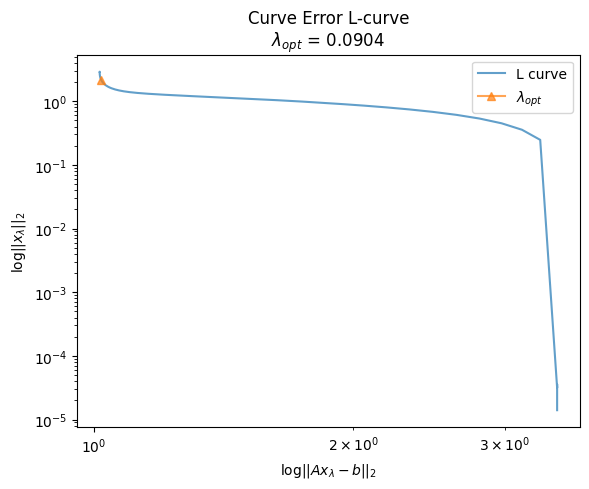

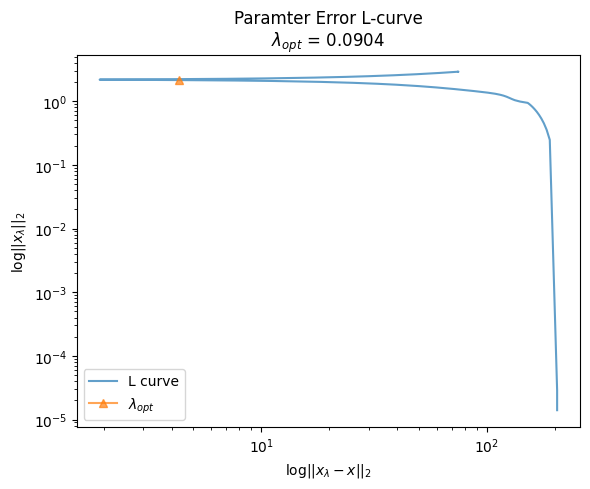

In [19]:
noiseless_curve = G(tdata, c1, c2, T21, T22)

add_noise(noiseless_curve, SNR)

param_list, error_list = generate_Lcurve_data(data, true_params, lambdas = lambdas_comprehensive)

err_min_ind = np.argmin(error_list)

param_list = np.array(param_list)
signals = []
for i in range(param_list.shape[0]):
    signals.append(G(tdata, *param_list[i,:]))

noisey_data_L2 = np.linalg.norm((signals - data), axis = 1, ord = 2)
assert(noisey_data_L2.shape[0] == param_list.shape[0])
soln_L2 = np.linalg.norm(param_list*agg_array, axis = 1, ord = 2)


fig = plt.figure(figsize=(6,5), tight_layout=True)
plt.loglog(noisey_data_L2, soln_L2, label= 'L curve', alpha = 0.7)
plt.loglog(noisey_data_L2[err_min_ind], soln_L2[err_min_ind], label= r'$\lambda_{opt}$', alpha = 0.7, marker = "^")
plt.xlabel(r'log||$Ax_{\lambda} - b$||$_2$')
plt.ylabel(r'log||$x_{\lambda}$||$_2$')
plt.title('Curve Error L-curve\n' + r'$\lambda_{opt}$ = ' + str(np.round(lambdas_comprehensive[err_min_ind],4)))
plt.legend()
plt.show()


#### X axis as parameter error as opposed to the curve error
est_param_error = np.linalg.norm((param_list - initial_params), axis = 1, ord = 2)
assert(est_param_error.shape[0] == param_list.shape[0])
soln_L2 = np.linalg.norm(param_list*agg_array, axis = 1, ord = 2)

fig = plt.figure(figsize=(6,5), tight_layout=True)
plt.loglog(est_param_error, soln_L2, label= 'L curve', alpha = 0.7)
plt.loglog(est_param_error[err_min_ind], soln_L2[err_min_ind], label= r'$\lambda_{opt}$', alpha = 0.7, marker = "^")
plt.xlabel(r'log||$x_{\lambda} - x$||$_2$')
plt.ylabel(r'log||$x_{\lambda}$||$_2$')
plt.title('Paramter Error L-curve\n' + r'$\lambda_{opt}$ = ' + str(np.round(lambdas_comprehensive[err_min_ind],4)))
plt.legend()
plt.show()

## Compare Methods for Optimal Lambda

1. L1 Grid Search
2. L2 Grid Search
3. L2 GSS
4. Fminbound

### Generate Simulation Data (For multiple samples)

In [100]:
def shuffle(tens):
    idx = torch.randperm(tens.size(0))
    new_tens = tens[idx]
    # new_tens = np.random.permutation(tens)
    if torch.equal(new_tens, tens):
        shuffle(tens)
    else:
        return new_tens

In [101]:
# num_samples = 100

# #Make cartesian product and convert to Tensor
# triplets = product(c1_set, T21_set, T22_set)
# new_triplets = np.array([x for x in triplets])
# tensor_targ_iter = torch.from_numpy(new_triplets)

# # Enforce T21 <= T22
# mask = torch.gt(tensor_targ_iter[:,2], tensor_targ_iter[:,3])
# tensor_targ_iter[mask,2] = tensor_targ_iter[mask,3]

# #Randomly shuffle the result
# tensor_targ_iter = shuffle(tensor_targ_iter)

# simulation_set = tensor_targ_iter[:num_samples]

### Run Simulations (One Sample - num_simulations of Noise Realizations)

In [20]:
# for c1, c2, T21, T22 in tqdm()
num_simulations = 100
num_decimals = 5        #How accurate do we need to be here

lamb_thresh = 10**-4


idx_to_type = {0: "Win_fminbnd", 1: "Win_GSS", 2: "Win_L2_Grid", 3: "Win_L1_Grid"}

type_to_count = {"Win_fminbnd": 0, "Win_GSS" : 0, "Win_L2_Grid": 0, "Win_L1_Grid": 0, "Tie" : 0}


noiseless_curve = G(tdata, c1, c2, T21, T22)

difference_matrix = np.ndarray((num_simulations,4))
lambda_matrix = np.ndarray((num_simulations,4))

for i in tqdm(range(num_simulations)): #noise realizations
    # np.random.seed(i)
    data = add_noise(noiseless_curve, SNR)
    unreg_params = estimate_parameters(data, 0)

    opt_params_comp, min_error_lambda_comp, _ = find_minLambda_L2grid_omni(data, true_params, 
                                lambdas = lambdas_comprehensive)
    opt_params_GSS, min_error_lambda_GSS, _, _ = find_minLambda_GSS_omni(data, true_params)

    opt_params_grid2, min_error_lambda_grid2, _ = find_minLambda_L2grid_omni(data, true_params, 
                                lambdas = lambdas_test)
    opt_params_grid1, min_error_lambda_grid1, _ = find_minLambda_L1grid_omni(data, true_params, 
                                lambdas = lambdas_test)
    fminbound_output = fminbound(lambda lamb: minLambda_objFunc(lamb, data, true_params),
                                lambdaA, lambdaB, xtol = GSS_tolerance)
    min_error_lambda_fmnbd = 10**fminbound_output

    compare = np.array(np.abs([min_error_lambda_fmnbd, min_error_lambda_GSS, min_error_lambda_grid2, min_error_lambda_grid1] - min_error_lambda_comp))
    compare = compare.round(decimals = num_decimals)
    idx = np.argmin(compare)

    lambda_matrix[i,0] = min_error_lambda_fmnbd
    lambda_matrix[i,1] = min_error_lambda_GSS
    lambda_matrix[i,2] = min_error_lambda_grid2
    lambda_matrix[i,3] = min_error_lambda_grid1

    difference_matrix[i,0] = min_error_lambda_fmnbd - min_error_lambda_comp
    difference_matrix[i,1] = min_error_lambda_GSS - min_error_lambda_comp
    difference_matrix[i,2] = min_error_lambda_grid2 - min_error_lambda_comp
    difference_matrix[i,3] = min_error_lambda_grid1 - min_error_lambda_comp

    out = np.where(compare == compare[idx])
    splice = compare[out] 
    splice_size = len(splice)
    match splice_size:
        case 2:
            type_to_count["Tie"] +=1
        case _:
            type_to_count[idx_to_type[idx]] +=1


display("Mean difference (gmnbd lambda - true lambda):\n", np.mean(difference_matrix, axis = 0)[0])
display("Mean difference (GSS lambda - true lambda):\n", np.mean(difference_matrix, axis = 0)[1])
display("Mean difference (grid L2 lambda - true lambda):\n", np.mean(difference_matrix, axis = 0)[1])
display("Mean difference (grid L1 lambda - true lambda):\n", np.mean(difference_matrix, axis = 0)[1])

display(type_to_count)



100%|██████████| 100/100 [07:55<00:00,  4.75s/it]


'Mean difference (gmnbd lambda - true lambda):\n'

0.9307862512793202

'Mean difference (GSS lambda - true lambda):\n'

3.628075013790544e-05

'Mean difference (grid L2 lambda - true lambda):\n'

3.628075013790544e-05

'Mean difference (grid L1 lambda - true lambda):\n'

3.628075013790544e-05

{'Win_fminbnd': 0,
 'Win_GSS': 74,
 'Win_L2_Grid': 2,
 'Win_L1_Grid': 0,
 'Tie': 24}

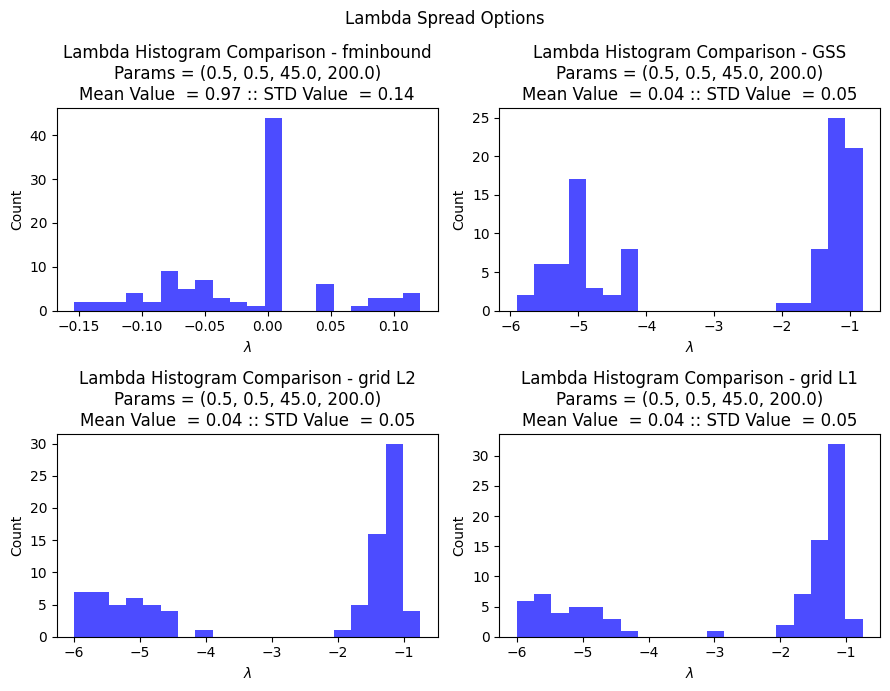

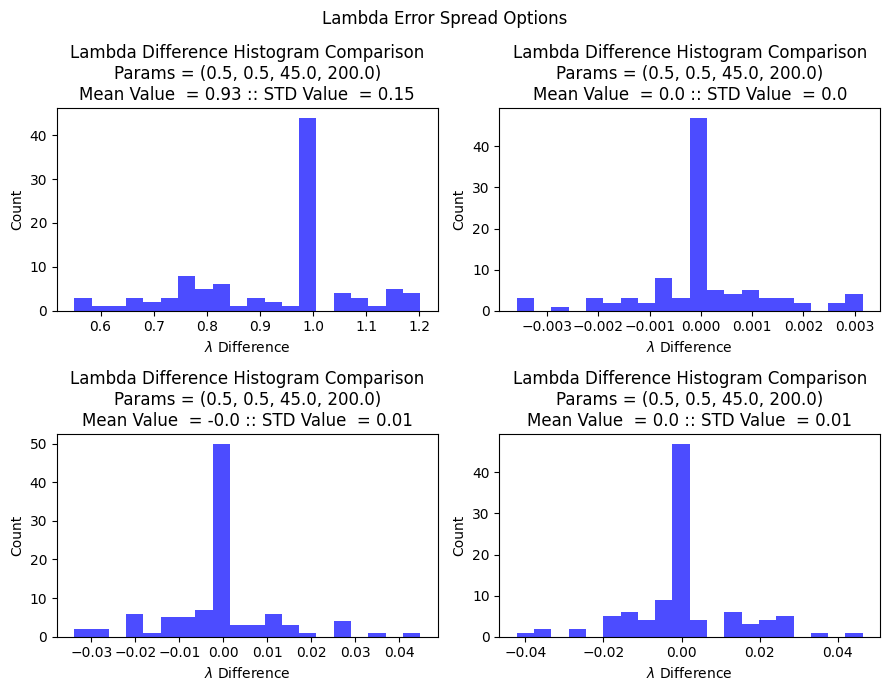

In [26]:
styleList = ("fminbound","GSS","grid L2","grid L1")
fig, ax = plt.subplots(2,2, figsize=(9,7), tight_layout=True)
fig.suptitle("Lambda Spread Options")
for i in range(lambda_matrix.shape[-1]):

    xax = i//2
    yax = i%2
    ax[xax, yax].hist(x=np.log10(lambda_matrix[lambda_matrix[:,i] > 0 ,i]), bins=20, color='b', label = styleList[i], alpha = 0.7)
    ax[xax, yax].set_xlabel(r'$\lambda$')
    ax[xax, yax].set_ylabel('Count')
    ax[xax, yax].set_title('Lambda Histogram Comparison - ' + styleList[i] +
        '\nParams = ('+ pList + ')' + 
        '\nMean Value  = ' + str(np.round(np.mean(lambda_matrix[:,i]),2)) + ' :: STD Value  = ' + str(np.round(np.std(lambda_matrix[:,i]),2)))
plt.show()


fig, ax = plt.subplots(2,2, figsize=(9,7), tight_layout=True)
fig.suptitle("Lambda Error Spread Options")
for i in range(difference_matrix.shape[-1]):
    xax = i//2
    yax = i%2
    ax[xax, yax].hist(x=difference_matrix[:,i], bins=20, color='b', label = styleList[i], alpha = 0.7)
    ax[xax, yax].set_xlabel(r'$\lambda$ Difference')
    ax[xax, yax].set_ylabel('Count')
    ax[xax, yax].set_title('Lambda Difference Histogram Comparison' + 
        '\nParams = ('+ pList + ')' + 
        '\nMean Value  = ' + str(np.round(np.mean(difference_matrix[:,i]),2)) + ' :: STD Value  = ' + str(np.round(np.std(difference_matrix[:,i]),2)))
plt.show()